In [1]:
# Set seeds for reproducibility
import random
random.seed(69)

import numpy as np
np.random.seed(69)

import tensorflow as tf
tf.random.set_seed(69)
import tensorflow as tf
print(tf.__version__)


2.10.0


In [2]:
# Allow memory growth on the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpu_available)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import gc
import re  # Import the regular expression module

# Clear session and garbage collection
K.clear_session()
gc.collect()

try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:  # Check if any GPUs are found
        gpu_device_name = gpus[0].name  # Get the full device name
        match = re.search(r'GPU:(\d+)', gpu_device_name)  # Extract "GPU:X"
        if match:
            short_gpu_name = match.group(0)  # This will be "GPU:0", "GPU:1", etc.
            tf.config.experimental.reset_memory_stats(short_gpu_name)
            print(f"Memory stats reset for device: {short_gpu_name}")
        else:
            print("Could not parse GPU device name.")
    else:
        print("No GPUs found. Skipping memory reset.")
except Exception as e:
    print(f"An error occurred during memory reset: {e}")


In [5]:
import os
import numpy as np
import cv2
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger, TerminateOnNaN
)

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.utils import class_weight, compute_class_weight, shuffle
from sklearn.model_selection import train_test_split

In [6]:
print(os.getcwd())
# Data Directories (REPLACE THESE WITH YOUR ACTUAL PATHS)
base_dir = os.getcwd()  # Contains subfolders for each class
train_dir = base_dir + "/train_val_test_split_384x384/train"
val_dir = base_dir + "/train_val_test_split_384x384/val"
test_dir = base_dir + "/train_val_test_split_384x384/test"
if os.path.exists(train_dir):
    print("File exists!")
else:
    print("File NOT found!")
if os.path.exists(val_dir):
    print("File exists!")
else:
    print("File NOT found!")
if os.path.exists(test_dir):
    print("File exists!")
else:
    print("File NOT found!")    

C:\Users\WWWZX\AI_Class_Work\cnn_split\casia2data
File exists!
File exists!
File exists!


In [ ]:
# Ensure your original convert_to_ela_image function is defined somewhere:
def convert_to_ela_image(image_path, quality=90, img_size=256):
    """Converts an image to its ELA representation using file-based processing."""
    temp_filename = "temp_ela.jpg"
    image = Image.open(image_path).convert("RGB")
    image.save(temp_filename, "JPEG", quality=quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    ela_image = ela_image.resize((256, 256))
    return np.array(ela_image) / 255.0  # Normalize to [0,1]

class ELAImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, img_size, class_mode="binary", shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.class_mode = class_mode
        self.shuffle = shuffle

        self.classes = {"au": 0, "tp": 1}  # Assign class labels
        self.image_paths, self.labels = self._load_image_paths_and_labels()
        self.labels = list(self.labels)  # Ensure labels are a list
        self.on_epoch_end()  # Shuffle initially if needed
    
    def _load_image_paths_and_labels(self):
        """Loads all image paths and labels from the directory."""
        image_paths = []
        labels = []
        for class_name, label in self.classes.items():
            class_path = os.path.join(self.directory, class_name)
            if os.path.exists(class_path):
                for filename in os.listdir(class_path):
                    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
                        image_paths.append(os.path.join(class_path, filename))
                        labels.append(label)
        return image_paths, labels

    def __len__(self):
        """Returns the total number of batches (including any partial batch)."""
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.image_paths))
        
        batch_image_paths = self.image_paths[start_idx:end_idx]
        batch_labels = self.labels[start_idx:end_idx]
        
        X, Y = self._generate_batch(batch_image_paths, batch_labels)
        return X, Y

    def _generate_batch(self, batch_image_paths, batch_labels):
        """Generates a batch of images (converted to ELA) and corresponding labels."""
        # Apply ELA conversion to each image in the batch.
        batch_images = [convert_to_ela_image(img_path, quality=90, img_size=self.img_size) 
                        for img_path in batch_image_paths]
        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        """Shuffles the dataset after each epoch."""
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)
            # Convert back to list and array respectively:
            self.image_paths = list(self.image_paths)
            self.labels = list(self.labels)


In [8]:
# Image Parameters
img_size = 384  # Or your desired size
batch_size = 32 # Adjust as needed

In [9]:
# Use Custom ELA Data Generators
train_generator = ELAImageDataGenerator(directory=train_dir, batch_size=batch_size, img_size=img_size)
val_generator = ELAImageDataGenerator(directory=val_dir, batch_size=batch_size, img_size=img_size)
test_generator = ELAImageDataGenerator(directory=test_dir, batch_size=batch_size, img_size=img_size, shuffle=False)
print("ELA-based data generators are ready!")

ELA-based data generators are ready!


In [8]:
#for debugging purpose only
# batch_images, batch_labels = train_generator[0]  # Assuming train_generator is now ELA-based
# print("Min pixel value:", np.min(batch_images))
# print("Max pixel value:", np.max(batch_images))

In [11]:
#Define your class mapping manually
inverse_class_map = {0: "au", 1: "tp"}  # Adjust this according to your dataset

# Get class distributions for training set
unique_classes, class_counts = np.unique(train_generator.labels, return_counts=True)
class_labels = [inverse_class_map[i] for i in unique_classes]
print("Train Class Distribution:", dict(zip(class_labels, class_counts)))

# Get class distributions for validation set
unique_classes, class_counts = np.unique(val_generator.labels, return_counts=True)
class_labels = [inverse_class_map[i] for i in unique_classes]
print("Validation Class Distribution:", dict(zip(class_labels, class_counts)))

# Get class distributions for test set
unique_classes, class_counts = np.unique(test_generator.labels, return_counts=True)
class_labels = [inverse_class_map[i] for i in unique_classes]
print("Test Class Distribution:", dict(zip(class_labels, class_counts)))

Train Class Distribution: {'au': 4498, 'tp': 965}
Validation Class Distribution: {'au': 964, 'tp': 206}
Test Class Distribution: {'au': 976, 'tp': 208}


In [1]:
#for debugging purposes
# print(dir(train_generator))  # See available attributes
# print(type(train_generator.classes))  # Should be list or np.ndarray
# print(train_generator.classes)  # See what it contains


In [2]:
#for debugging purpose only
# # Check if 'labels' is accessible and not empty
# if hasattr(train_generator, "labels") and train_generator.labels:
#     train_classes = np.array(train_generator.labels)  # Extract labels
#     print("Extracted Labels:", train_classes[:10])  # Print first 10 labels
# else:
#     raise AttributeError("train_generator does not have a valid 'labels' attribute.")


In [14]:
# Ensure train_classes is correctly extracted
train_classes = np.array(train_generator.labels)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_classes), 
    y=train_classes
)

class_weight_dict = dict(zip(np.unique(train_classes), class_weights))
print("Computed Class Weights:", class_weight_dict)


Computed Class Weights: {0: 0.6072698977323254, 1: 2.8305699481865285}


In [15]:
# Load VGG16 with ImageNet weights, without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
base_model.trainable = False


In [16]:
# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.38),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 384, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 384, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 192, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 96, 128)       0     

In [17]:
print(len(base_model.layers))

22


In [18]:
def focal_loss(alpha=0.5, gamma=3.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())  # Convert labels to float32
        epsilon = K.epsilon()  # Small value to avoid log(0)
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)  # Clip predictions

        bce = K.binary_crossentropy(y_true, y_pred)  # Compute binary cross-entropy
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)  # Probabilities
        focal_factor = alpha * K.pow(1 - p_t, gamma)  # Focal weighting

        return K.mean(focal_factor * bce)  # Weighted BCE
    return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  

In [22]:
model.compile(
    optimizer=optimizer,
    loss=focal_loss(alpha=0.25, gamma=2.0),  
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("success of this block")

success of this block


In [23]:
# Callbacks (Early Stopping and ReduceLROnPlateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True,verbose=2) #stop training when validation loss is not decreasing
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.35, patience=5, min_lr=1e-8,verbose=2) #reduce learning rate when validation loss is not decreasing
checkpoint_callback = ModelCheckpoint(filepath='checkpoints/model_{epoch:02d}.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=2)
tensorboard_callback = TensorBoard(log_dir="Tensor_Board_Logs", histogram_freq=1,)
csv_logger = CSVLogger('training_log.csv')
nan_terminator = TerminateOnNaN()

print("success of this block")

success of this block


In [24]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback, nan_terminator]
)

print("Training complete!")


Epoch 1/50
171/171 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.7591 - precision: 0.4125 - recall: 0.8570           
Epoch 1: val_loss improved from inf to 0.02699, saving model to checkpoints\model_01.h5
171/171 [==============================] - 74s 365ms/step - loss: 0.0348 - accuracy: 0.7591 - precision: 0.4125 - recall: 0.8570 - val_loss: 0.0270 - val_accuracy: 0.8239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
171/171 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.8742 - precision: 0.6153 - recall: 0.7689          
Epoch 2: val_loss improved from 0.02699 to 0.02410, saving model to checkpoints\model_02.h5
171/171 [==============================] - 59s 342ms/step - loss: 0.0215 - accuracy: 0.8742 - precision: 0.6153 - recall: 0.7689 - val_loss: 0.0241 - val_accuracy: 0.8239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/50
171/171 [==============================]

In [25]:
#Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True

# Optionally, freeze the earlier layers to avoid overfitting
fine_tune_at = 14  # Freeze layers from 0 to 14 and fine-tune layers 15 onward
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=focal_loss(alpha=0.5, gamma=3.0),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [27]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Use predefined dataset size
    epochs=50,  
    validation_data=val_generator,  # Use val_generator instead
    validation_steps=len(val_generator),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback, nan_terminator]
)

Epoch 1/50
171/171 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9200 - precision_1: 0.7833 - recall_1: 0.7565   
Epoch 1: val_loss did not improve from 0.01100
171/171 [==============================] - 66s 366ms/step - loss: 0.0167 - accuracy: 0.9200 - precision_1: 0.7833 - recall_1: 0.7565 - val_loss: 0.0130 - val_accuracy: 0.9308 - val_precision_1: 0.9699 - val_recall_1: 0.6262 - lr: 1.0000e-05
Epoch 2/50
171/171 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9394 - precision_1: 0.8484 - recall_1: 0.8000  
Epoch 2: val_loss did not improve from 0.01100
171/171 [==============================] - 65s 381ms/step - loss: 0.0134 - accuracy: 0.9394 - precision_1: 0.8484 - recall_1: 0.8000 - val_loss: 0.2680 - val_accuracy: 0.3205 - val_precision_1: 0.2058 - val_recall_1: 1.0000 - lr: 1.0000e-05
Epoch 3/50
171/171 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9502 - precision_1: 0.8682 - recall_1: 0.8466  
Epoch 

In [28]:
print("Evaluating on Test Data...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    test_generator,
    steps=len(test_generator)
)

Evaluating on Test Data...
37/37 [==============================] - 11s 289ms/step - loss: 0.0102 - accuracy: 0.9620 - precision_1: 0.8900 - recall_1: 0.8942  


In [29]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")


Test Loss: 0.0102
Test Accuracy: 96.20%
Test Precision: 89.00%
Test Recall: 89.42%


In [30]:
# Compute F1 Score
if (test_precision + test_recall) > 0:
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
else:
    test_f1 = 0
print(f"Test F1 Score: {test_f1 * 100:.2f}%")

Test F1 Score: 89.21%


In [31]:
true_labels = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]  # Extract batch labels
    true_labels.extend(labels)

true_labels = np.array(true_labels)  # Convert list to NumPy array

test_predictions = model.predict(test_generator)
test_predictions = test_predictions.flatten()  # Ensure correct shape

37/37 [==============================] - 11s 283ms/step


In [32]:
precisions, recalls, thresholds = precision_recall_curve(true_labels, test_predictions)

f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)  # Avoid division by zero
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal threshold: {best_threshold:.4f}")

Optimal threshold: 0.4648


In [33]:
# Generate predictions
steps = len(test_generator)  # Ensure consistency
test_predictions = model.predict(test_generator, steps=steps)

# Convert probabilities to binary predictions
threshold = best_threshold
predicted_classes = (test_predictions > threshold).astype(int)

# Trim true labels to match predictions
true_labels = np.array(test_generator.labels)

# Ensure no mismatches
assert len(true_labels) == len(predicted_classes), "Mismatch in true labels and predictions!"



37/37 [==============================] - 10s 277ms/step


In [5]:
#for debugginfg purpose only
# true_labels = test_generator.labels  # Check if this exists

In [6]:
#for debugginfg purpose only
# print(len(true_labels))  
# print(len(predicted_classes))  

In [36]:
true_labels = np.array(true_labels)  # Convert list to NumPy array
predicted_classes = np.array(predicted_classes)  # Ensure predictions are also an array

print(f"Shape of true_labels: {true_labels.shape}")  
print(f"Shape of predicted_classes: {predicted_classes.shape}")  

Shape of true_labels: (1184,)
Shape of predicted_classes: (1184, 1)


In [38]:
print(f"Shape of true_labels: {true_labels.shape}")  
print(f"Shape of predicted_classes: {predicted_classes.shape}")  

Shape of true_labels: (1184,)
Shape of predicted_classes: (1184, 1)


In [7]:
#for debugging purposes 
# print(type(true_labels))  # Check the type of true_labels
# print(true_labels)  # Print its contents

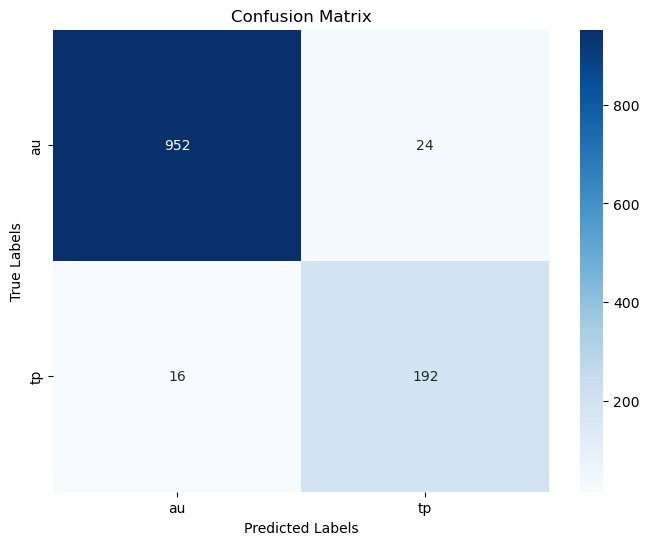

In [40]:
cm = confusion_matrix(true_labels, predicted_classes)
class_labels = ["au", "tp"]  # Adjust according to your dataset\
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
print("Classification Report:")
class_labels = ["au", "tp"]  # Adjust according to your dataset
print(classification_report(true_labels, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

          au       0.98      0.98      0.98       976
          tp       0.89      0.92      0.91       208

    accuracy                           0.97      1184
   macro avg       0.94      0.95      0.94      1184
weighted avg       0.97      0.97      0.97      1184



In [42]:
precision = precision_score(true_labels, predicted_classes, zero_division=1)
recall = recall_score(true_labels, predicted_classes, zero_division=1)

In [43]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.8889
Recall: 0.9231


In [44]:
print("Class distribution in predictions:", np.unique(predicted_classes, return_counts=True))


Class distribution in predictions: (array([0, 1]), array([968, 216], dtype=int64))


In [46]:
model.save("models/v4.h5")
model.save("models/v4.keras")

